# Purpose
Taking the results of 13fs.ipynb and the `13f_dtw_features.csv` file that was outputted, lets see about determining how DTW will work on this data and how many clusters


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
pd.set_option('use_inf_as_na', True)
from fastdtw import fastdtw
from joblib import dump, load

Matplotlib is building the font cache; this may take a moment.


In [2]:
features = pd.read_csv('13f_dtw_features.csv')

In [3]:
full_re_run = False

In [4]:
features.head()

,FilerId,FilingId,Period,TurnOver,PercentValue,num_10_pct,num_20_pct,num_50_pct
0,1,1,2014-1,0.000000,100.0,2.0,7.0,25.0
1,1,3776,2014-2,0.221153,100.0,2.0,6.0,24.0
2,1,7584,2014-3,0.162403,100.0,2.0,7.0,25.0
3,1,11425,2014-4,0.017355,100.0,2.0,6.0,25.0
4,1,15237,2015-1,0.154250,100.0,2.0,7.0,24.0


As expected, our data frame has our limited MVP feature set defined.  

* Turn Over - indicates hold time
* num_x_pct - indicates concentration level
* PercentValue - check value to indicate our previous aggregate is correct

Lets grab a couple filers and see what a Fast DTW looks like, using euclidean distance here for a quick POC

In [5]:
a_df = features[features['FilerId']==867]
b_df = features[features['FilerId']==964].fillna(0)

In [6]:
turnover_distance, path = fastdtw(a_df['TurnOver'], b_df['TurnOver'], dist=euclidean)
num_10_pct_distance, path = fastdtw(a_df['num_10_pct'], b_df['num_10_pct'], dist=euclidean)
num_20_pct_distance, path = fastdtw(a_df['num_20_pct'], b_df['num_20_pct'], dist=euclidean)
num_50_pct_distance, path = fastdtw(a_df['num_50_pct'], b_df['num_50_pct'], dist=euclidean)

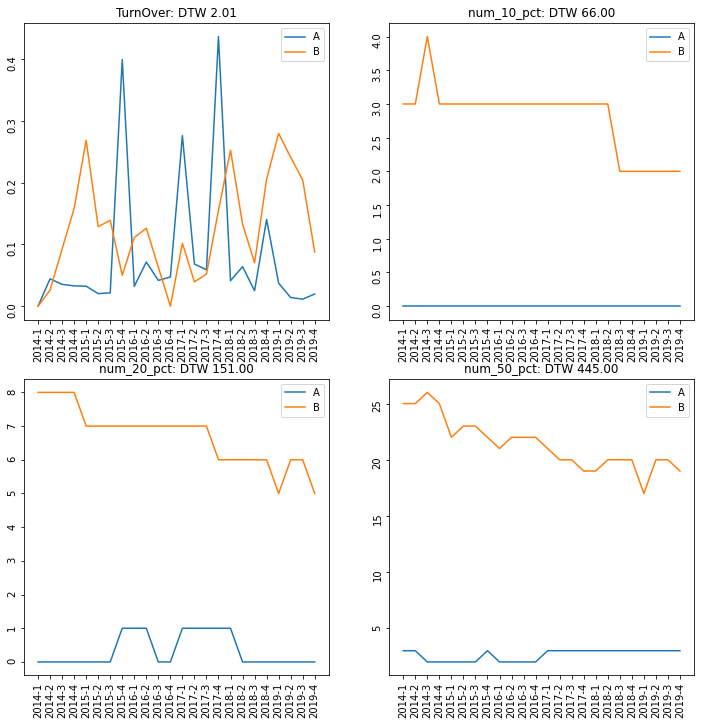

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
axs[0, 0].plot(a_df['Period'], a_df['TurnOver'], label='A')
axs[0, 0].plot(b_df['Period'], b_df['TurnOver'], label='B')
axs[0, 0].set_title(f'TurnOver: DTW {turnover_distance:0.2f}')
axs[0, 0].legend()
axs[0, 0].tick_params(labelrotation=90)

axs[0, 1].plot(a_df['Period'], a_df['num_10_pct'], label='A')
axs[0, 1].plot(b_df['Period'], b_df['num_10_pct'], label='B')
axs[0, 1].set_title(f'num_10_pct: DTW {num_10_pct_distance:0.2f}')
axs[0, 1].legend()
axs[0, 1].tick_params(labelrotation=90)

axs[1, 0].plot(a_df['Period'], a_df['num_20_pct'], label='A')
axs[1, 0].plot(b_df['Period'], b_df['num_20_pct'], label='B')
axs[1, 0].set_title(f'num_20_pct: DTW {num_20_pct_distance:0.2f}')
axs[1, 0].legend()
axs[1, 0].tick_params(labelrotation=90)

axs[1, 1].plot(a_df['Period'], a_df['num_50_pct'], label='A')
axs[1, 1].plot(b_df['Period'], b_df['num_50_pct'], label='B')
axs[1, 1].set_title(f'num_50_pct: DTW {num_50_pct_distance:0.2f}')
axs[1, 1].legend()
axs[1, 1].tick_params(labelrotation=90)

plt.savefig('brk_orleans.png')

The above charts show that `A` turnover is often lower, with peaky periods and that `A` is a MUCH higher concentrated portfiolio than `B`

on a similar scale though, `A` and `B` are close in turnover as compared to `A` and `B` for concentration

Curiously, how far apart is the same two?

In [8]:
distance, path = fastdtw(
    features.sample()['TurnOver'],
    features.sample()['TurnOver'],
    dist=euclidean
)
print(distance)

0.1494542279514719


# The Show

Here lets try to use tslearn, having got a little intution above using FastDTW using single-variate DTW, now lets do multi-variate DTW

In [9]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import from_tsfresh_dataset, to_tsfresh_dataset
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax

c:\users\kenfa\appdata\local\pypoetry\cache\virtualenvs\research-13f-a3uaaj79-py3.8\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Get JUST what we need for training

In [10]:
features_2 = features.rename(columns={'FilerId': 'id', 'Period': 'time'})[['id', 'time', 'TurnOver', 'num_10_pct', 'num_20_pct', 'num_50_pct']]

In [11]:
features_2.head()

,id,time,TurnOver,num_10_pct,num_20_pct,num_50_pct
0,1,2014-1,0.000000,2.0,7.0,25.0
1,1,2014-2,0.221153,2.0,6.0,24.0
2,1,2014-3,0.162403,2.0,7.0,25.0
3,1,2014-4,0.017355,2.0,6.0,25.0
4,1,2015-1,0.154250,2.0,7.0,24.0


In [12]:
features_2.describe()

,id,TurnOver,num_10_pct,num_20_pct,num_50_pct
count,106970.000000,106970.000000,106970.000000,106970.000000,106970.000000
mean,2690.184650,6.123373,1.360026,3.936655,17.819071
std,1664.739418,1877.772754,2.526145,5.643700,24.674848
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1293.000000,0.072439,0.000000,1.000000,4.000000
50%,2596.000000,0.179498,1.000000,2.000000,11.000000
75%,3899.000000,0.363377,2.000000,5.000000,22.000000
max,6936.000000,614143.658063,395.000000,403.000000,1224.000000


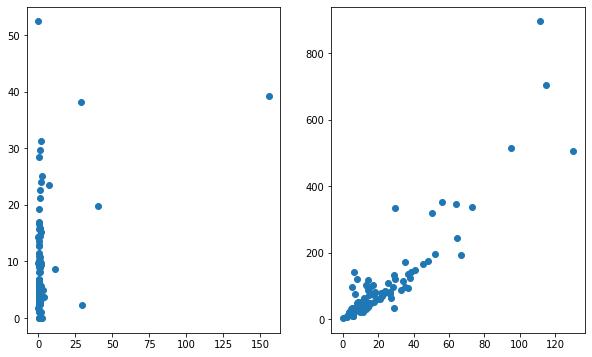

In [13]:
# Lets plot TurnOver v num_10_pct for a random sample of 100
turn_over = []
num_10_pct = []
num_20_pct = []
num_50_pct = []

for _ in range(100):
    a = features_2.sample()
    b = features_2.sample()
    
    turn_over.append(dtw(features_2[features_2['id'] == a['id'].iloc[0]]['TurnOver'].values,features_2[features_2['id'] == b['id'].iloc[0]]['TurnOver'].values))
    num_10_pct.append(dtw(features_2[features_2['id'] == a['id'].iloc[0]]['num_10_pct'].values,features_2[features_2['id'] == b['id'].iloc[0]]['num_10_pct'].values))
    num_20_pct.append(dtw(features_2[features_2['id'] == a['id'].iloc[0]]['num_20_pct'].values,features_2[features_2['id'] == b['id'].iloc[0]]['num_20_pct'].values))
    num_50_pct.append(dtw(features_2[features_2['id'] == a['id'].iloc[0]]['num_50_pct'].values,features_2[features_2['id'] == b['id'].iloc[0]]['num_50_pct'].values))
    
fix, axs = plt.subplots(1,2, figsize=(10, 6))
axs[0].scatter(turn_over, num_10_pct)
axs[1].scatter(num_20_pct, num_50_pct)
    

For turn_over vs num_10_pct, that one way out there is skewing the results a bit, but we're hovering around zero for turn-over.  I'm thinking we may need better/different normalization for all of these.

For num_20_pct vs num_50_pct -- not surprising that as one goes up the other does too.  

<AxesSubplot:>

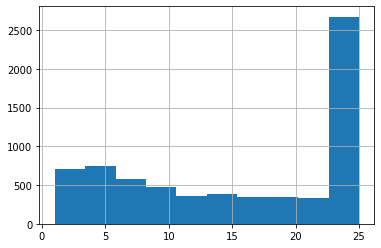

In [15]:
features_2.groupby('id')['time'].count().hist()

In [16]:
id = features_2['id'].sample().values[0]
print(id)
features_2[
    features_2['id']==id
]

5589


,id,time,TurnOver,num_10_pct,num_20_pct,num_50_pct
101189,5589,2018-1,0.000000,2.0,5.0,17.0
101190,5589,2018-2,0.232608,2.0,5.0,18.0
101191,5589,2018-3,0.165227,2.0,4.0,19.0
101192,5589,2018-4,0.123219,1.0,4.0,18.0
101193,5589,2019-1,0.119242,1.0,4.0,16.0
101194,5589,2019-2,0.307091,1.0,4.0,18.0
101195,5589,2019-3,0.225565,1.0,4.0,18.0
101196,5589,2019-4,0.277287,1.0,3.0,15.0
101197,5589,2020-1,0.237716,1.0,3.0,16.0


Hmm, okay, we don't have consistent filers for all periods.  As this is the first time doing DTW, lets simplify this experiment and keep only filers with full entries.

In [17]:
periods = ['2014-1', '2014-2', '2014-3', '2014-4',
           '2015-1', '2015-2', '2015-3', '2015-4',
           '2016-1', '2016-2', '2016-3', '2016-4',
           '2017-1', '2017-2', '2017-3', '2017-4',
           '2018-1', '2018-2', '2018-3', '2018-4',
           '2019-1', '2019-2', '2019-3', '2019-4',
           '2020-1']

In [18]:
# drop all those that are not in this period range
features_3 = features_2[
    features_2['time'].isin(periods)
]

In [19]:
features_3['time'].unique()

array(['2014-1', '2014-2', '2014-3', '2014-4', '2015-1', '2015-2',
       '2015-3', '2015-4', '2016-1', '2016-2', '2016-3', '2016-4',
       '2017-1', '2017-2', '2017-3', '2017-4', '2018-1', '2018-2',
       '2018-3', '2018-4', '2019-1', '2019-2', '2019-3', '2019-4',
       '2020-1'], dtype=object)

In [20]:
for period in periods:
    missing = features_3[~features_3['id'].isin(features_3[features_3['time']==period]['id'].unique())]['id'].unique()
    print(f"have {missing.shape[0]} missing from period {period}")

    k = pd.DataFrame(missing, columns=['id'])
    k['time'] = period
    k['TurnOver'] = 0
    k['num_10_pct'] = 0
    k['num_20_pct'] = 0
    k['num_50_pct'] = 0
    k
    
    features_3 = features_3.append(k, ignore_index=True)

have 3302 missing from period 2014-1
have 3249 missing from period 2014-2
have 3213 missing from period 2014-3
have 3225 missing from period 2014-4
have 2977 missing from period 2015-1
have 2931 missing from period 2015-2
have 2892 missing from period 2015-3
have 2904 missing from period 2015-4
have 2770 missing from period 2016-1
have 2779 missing from period 2016-2
have 2765 missing from period 2016-3
have 2802 missing from period 2016-4
have 2637 missing from period 2017-1
have 2631 missing from period 2017-2
have 2617 missing from period 2017-3
have 2628 missing from period 2017-4
have 2334 missing from period 2018-1
have 2282 missing from period 2018-2
have 2277 missing from period 2018-3
have 2268 missing from period 2018-4
have 1973 missing from period 2019-1
have 1953 missing from period 2019-2
have 1984 missing from period 2019-3
have 1982 missing from period 2019-4
have 3155 missing from period 2020-1


<AxesSubplot:>

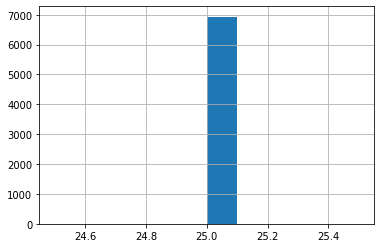

In [21]:
features_3.groupby('id')['time'].count().hist()

In [22]:
features_3.shape

(173375, 6)

Okay, no longer missing data, lets rock and roll with some data manipulation

In [23]:
dta_3 = from_tsfresh_dataset(features_3)
dta_scaled_3 = TimeSeriesScalerMeanVariance().fit_transform(dta_3)

How many clusters?  let the list of x contain all cluster sizes we will investigate....this will take some time

In [24]:
x = [1,2,3,4,5,10,15,20,30,40,50,60,70,80,100]
y = []

In [30]:
if full_re_run:
    for n_clusters in x:
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=10, n_init=10, max_iter=10, verbose=0).fit(dta_scaled_3)
        y.append(model.inertia_)

In [31]:
if full_re_run:
    clustering_results = pd.DataFrame({'num_clusters': x, 'inertia': y})
    clustering_results['change'] = clustering_results['inertia'].diff().abs().fillna(0)
    clustering_results.to_csv('clustering_results.csv', index=False)
else:
    clustering_results = pd.read_csv('clustering_results.csv')
clustering_results

,num_clusters,inertia,change
0,1,57.550470,0.000000
1,2,48.606321,8.944149
2,3,44.889574,3.716747
3,4,42.121810,2.767764
4,5,40.141740,1.980070
5,10,34.620881,5.520859
6,15,32.734762,1.886119
7,20,31.189475,1.545287
8,30,28.919979,2.269495
9,40,27.579913,1.340067


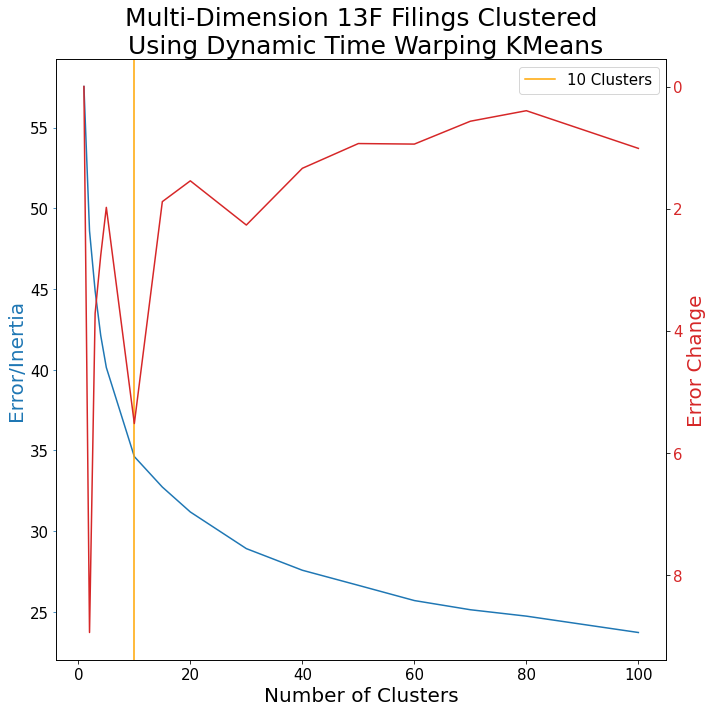

In [32]:
fig, ax1 = plt.subplots(figsize=(10,10))

plt.title('Multi-Dimension 13F Filings Clustered\n Using Dynamic Time Warping KMeans', fontsize=25)

ax1.set_xlabel('Number of Clusters', fontsize=20)
ax1.tick_params(axis='x', labelsize=15)

color = 'tab:blue'
ax1.set_ylabel('Error/Inertia', fontsize=20, color=color)
ax1.plot(clustering_results['num_clusters'],clustering_results['inertia'], color=color)
ax1.tick_params(axis='y', labelsize=15, color=color)


color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Error Change', color=color, fontsize=20)
ax2.plot(clustering_results['num_clusters'],clustering_results['change'], color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)
ax2.set_ylim(ax2.get_ylim()[::-1])

ax1.axvline(10, color='orange', label='10 Clusters')

ax1.legend(fontsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('dtw-kmeans.png')
plt.show()

Our Error slope peaked around 10 clusters -- good enough for now

In [33]:
if full_re_run:
    k10_model = TimeSeriesKMeans(n_clusters=10, metric="dtw", random_state=10, n_init=10, max_iter=10, verbose=0).fit(dta_scaled_3)
    dump(k10_model, 'k10_model.joblib')
else:
    k10_model = load('k10_model.joblib') 

In [34]:
if full_re_run:
    max_val = features_3.groupby('id').max().reset_index()
    min_val = features_3.groupby('id').min().reset_index()
    avg_val = features_3.groupby('id').mean().reset_index()
    
    filers = pd.DataFrame({
    'FilingId': features_3['id'].unique(), 
    'Cluster': k10_model.labels_,
    'max_turnover': max_val['TurnOver'],
    'max_num_10_pct': max_val['num_10_pct'],
    'max_num_20_pct': max_val['num_20_pct'],
    'max_num_50_pct': max_val['num_50_pct'],
    'min_turnover': min_val['TurnOver'],
    'min_num_10_pct': min_val['num_10_pct'],
    'min_num_20_pct': min_val['num_20_pct'],
    'min_num_50_pct': min_val['num_50_pct'],
    'avg_turnover': avg_val['TurnOver'],
    'avg_num_10_pct': avg_val['num_10_pct'],
    'avg_num_20_pct': avg_val['num_20_pct'],
    'avg_num_50_pct': avg_val['num_50_pct'],
    })
    filers.to_csv('filers_clustered.csv', index=False)
else:
    filers = pd.read_csv('filers_clustered.csv')

In [35]:
filers.head()

,FilingId,Cluster,max_turnover,max_num_10_pct,max_num_20_pct,max_num_50_pct,min_turnover,min_num_10_pct,min_num_20_pct,min_num_50_pct,avg_turnover,avg_num_10_pct,avg_num_20_pct,avg_num_50_pct
0,1,0,0.385279,3.0,7.0,27.0,0.0,1.0,5.0,22.0,0.154645,2.20,6.36,24.40
1,2,5,0.178518,4.0,9.0,24.0,0.0,4.0,8.0,22.0,0.054295,4.00,8.48,23.04
2,3,0,0.978946,2.0,10.0,65.0,0.0,0.0,0.0,0.0,0.303979,0.36,2.00,24.16
3,4,0,0.661354,3.0,8.0,41.0,0.0,0.0,1.0,5.0,0.340209,1.00,3.56,20.68
4,5,0,0.253957,3.0,13.0,68.0,0.0,0.0,6.0,51.0,0.162099,1.88,9.72,61.56


In [36]:
filtered_filers = filers[filers['max_turnover']<200]
filtered_filers = filtered_filers[filtered_filers['max_num_10_pct']<100]

In [37]:
label_color = [f'C{l}' for l in filtered_filers['Cluster']]

(0.0, 0.6)

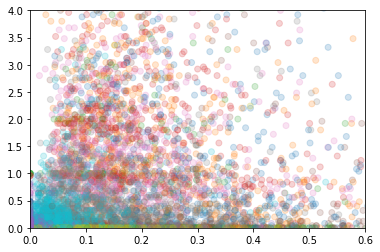

In [45]:
plt.scatter(filtered_filers['avg_turnover'], filtered_filers['avg_num_10_pct'], color=label_color, alpha=0.2)
plt.ylim(0,4)
plt.xlim(0,0.6)

enhance

(0.0, 0.75)

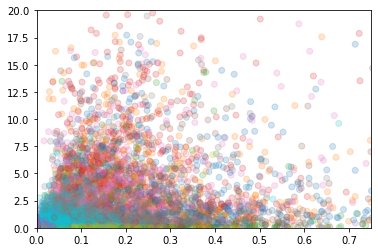

In [48]:
plt.scatter(filtered_filers['avg_turnover'], filtered_filers['avg_num_20_pct'], color=label_color, alpha=0.2)
plt.ylim(0,20)
plt.xlim(0,0.75)

enhance

(0.0, 0.5)

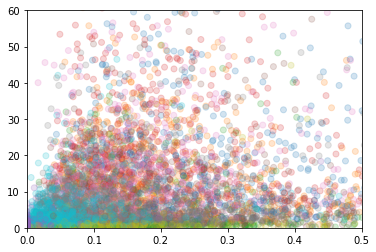

In [51]:
plt.scatter(filtered_filers['avg_turnover'], filtered_filers['avg_num_50_pct'], color=label_color, alpha=0.2)
plt.ylim(0,60)
plt.xlim(0,0.5)

In [54]:
# how many filers fall into each group?
filtered_filers['Cluster'].value_counts()

7    967
2    821
9    795
8    685
3    679
0    643
6    633
1    606
5    554
4    541
Name: Cluster, dtype: int64

In [55]:
filtered_filers.head()

,FilingId,Cluster,max_turnover,max_num_10_pct,max_num_20_pct,max_num_50_pct,min_turnover,min_num_10_pct,min_num_20_pct,min_num_50_pct,avg_turnover,avg_num_10_pct,avg_num_20_pct,avg_num_50_pct
0,1,0,0.385279,3.0,7.0,27.0,0.0,1.0,5.0,22.0,0.154645,2.20,6.36,24.40
1,2,5,0.178518,4.0,9.0,24.0,0.0,4.0,8.0,22.0,0.054295,4.00,8.48,23.04
2,3,0,0.978946,2.0,10.0,65.0,0.0,0.0,0.0,0.0,0.303979,0.36,2.00,24.16
3,4,0,0.661354,3.0,8.0,41.0,0.0,0.0,1.0,5.0,0.340209,1.00,3.56,20.68
4,5,0,0.253957,3.0,13.0,68.0,0.0,0.0,6.0,51.0,0.162099,1.88,9.72,61.56


In [56]:
filtered_filers[filtered_filers['FilingId']==867]

,FilingId,Cluster,max_turnover,max_num_10_pct,max_num_20_pct,max_num_50_pct,min_turnover,min_num_10_pct,min_num_20_pct,min_num_50_pct,avg_turnover,avg_num_10_pct,avg_num_20_pct,avg_num_50_pct
866,867,2,0.436143,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.078746,0.0,0.32,2.52


In [63]:
filtered_filers['avg_turnover'].describe()

count    6924.000000
mean        0.194481
std         0.529637
min         0.000000
25%         0.049510
50%         0.122242
75%         0.231842
max        14.415038
Name: avg_turnover, dtype: float64

In [65]:
filtered_filers[filtered_filers['avg_turnover']>5]

,FilingId,Cluster,max_turnover,max_num_10_pct,max_num_20_pct,max_num_50_pct,min_turnover,min_num_10_pct,min_num_20_pct,min_num_50_pct,avg_turnover,avg_num_10_pct,avg_num_20_pct,avg_num_50_pct
8,9,1,21.906510,5.0,16.0,103.0,0.0,2.0,12.0,86.0,7.197923,3.08,13.84,94.68
594,595,3,45.995207,9.0,26.0,132.0,0.0,0.0,0.0,0.0,8.664259,7.36,20.60,109.40
684,685,3,72.484015,6.0,16.0,89.0,0.0,0.0,0.0,0.0,14.415038,4.48,13.36,73.12
799,800,5,102.580254,9.0,27.0,165.0,0.0,0.0,1.0,9.0,13.614277,5.28,17.00,104.64
834,835,3,81.978298,8.0,22.0,110.0,0.0,0.0,0.0,0.0,9.103787,6.36,17.40,92.76
887,888,9,66.403643,18.0,49.0,249.0,0.0,0.0,0.0,0.0,6.283535,3.44,14.68,123.84
1570,1571,0,127.314905,7.0,20.0,127.0,0.0,0.0,0.0,0.0,13.108725,3.92,13.84,88.64
1571,1572,7,146.254999,11.0,32.0,237.0,0.0,0.0,0.0,0.0,9.795899,4.92,13.96,99.52
1573,1574,7,131.592774,6.0,19.0,108.0,0.0,0.0,0.0,0.0,10.104151,2.88,8.28,49.12
1906,1907,1,109.291661,9.0,23.0,84.0,0.0,0.0,0.0,0.0,10.708334,5.04,12.68,45.16


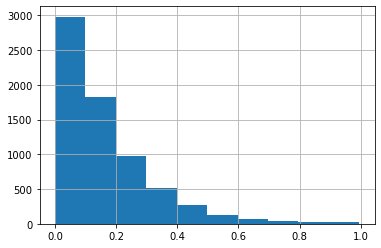

In [67]:
filtered_filers[filtered_filers['avg_turnover']<1]['avg_turnover'].hist()

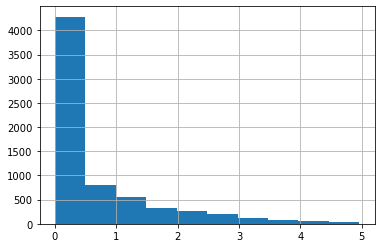

In [73]:
filtered_filers[filtered_filers['avg_num_10_pct']<5]['avg_num_10_pct'].hist()

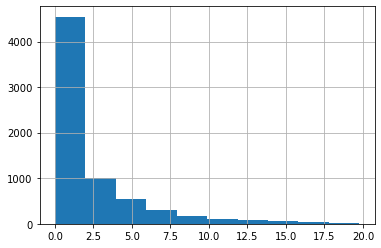

In [75]:
filtered_filers[filtered_filers['avg_num_20_pct']<20]['avg_num_20_pct'].hist()

In [77]:
buff_cluster = filtered_filers[filtered_filers['Cluster']==2]

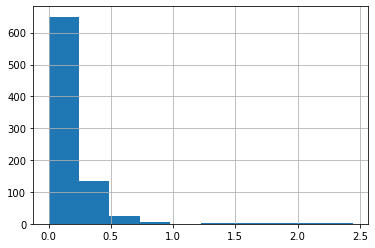

In [78]:
buff_cluster['avg_turnover'].hist()

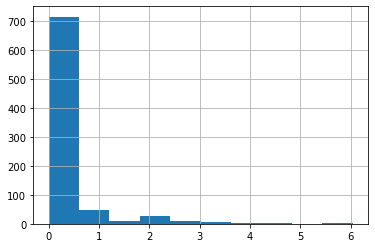

In [79]:
buff_cluster['avg_num_10_pct'].hist()

This may be worth more time with

* additional features
* normalize features -- I hypothesise that the scale of turn over and num_x_pcts are interfering
* is this more of a sparse recommendation??